In [1]:
library(glmnet)
library(superheat)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [2]:
load('../data/organSystem.Rdata')

In [17]:
get_os_prediction_from_PP <- function(A.matrix, os){
    # A.matrix is the matrix of pp coefficients
    
    # change column headings to match with os data
    genes <- gsub('\\..*', '', colnames(A.matrix))
    genes <- gsub('\\_.*', '', genes)
        
    # extract those genes for which we have annotations
    A.matrix <- A.matrix[ , genes %in% rownames(os)] 
    
    os.subset <- os[genes[genes %in% rownames(os)], ]
    
    print(dim(os.subset))
    print(dim(A.matrix))
        
    # get the late stage annotations
    # they have names *_4
    os.names <- colnames(os)
    CV.late4 <- os.names[grep("_4", os.names)]

    CV.late4 <- CV.late4[CV.late4 != 'imagPR_4'] # not enough genes w this annotation
    
    coefficients <- matrix(0, dim(A.matrix)[1] + 1, length(CV.late4))
    error_lasso_PP <- matrix(0,length(CV.late4), 1)

    for(i in 1:length(CV.late4)){
        y <- os.subset[, CV.late4[i]]

        cvfit <- cv.glmnet(t(A.matrix), y, family = 'binomial', 
                           type.measure = "auc")
        coefficients[,i] <- as.matrix(coef(cvfit, s = "lambda.1se"))
        error_lasso_PP[i, ] <- cvfit$cvm[cvfit$lambda == cvfit$lambda.1se]
    }

    rownames(coefficients) <- c('intercept', rownames(A.matrix))
    colnames(coefficients) <- sub("_4*", " ", CV.late4)

    rownames(error_lasso_PP) <- sub("_4*", " ", CV.late4)

    coeff_no_int <- coefficients[2:dim(coefficients)[1], ]
    
    return(list(coefficients = coeff_no_int, 
                error = error_lasso_PP))
}

# Predictions with 19 PPs

In [33]:
alpha_file <- '../scripts/staNMFDicts/K=19/alpha_99.csv'
alpha19 <- read.csv(alpha_file)[, -1]

In [42]:
lasso_pred19 <- get_os_prediction_from_PP(alpha19, os)

[1] 658  80
[1]  19 658


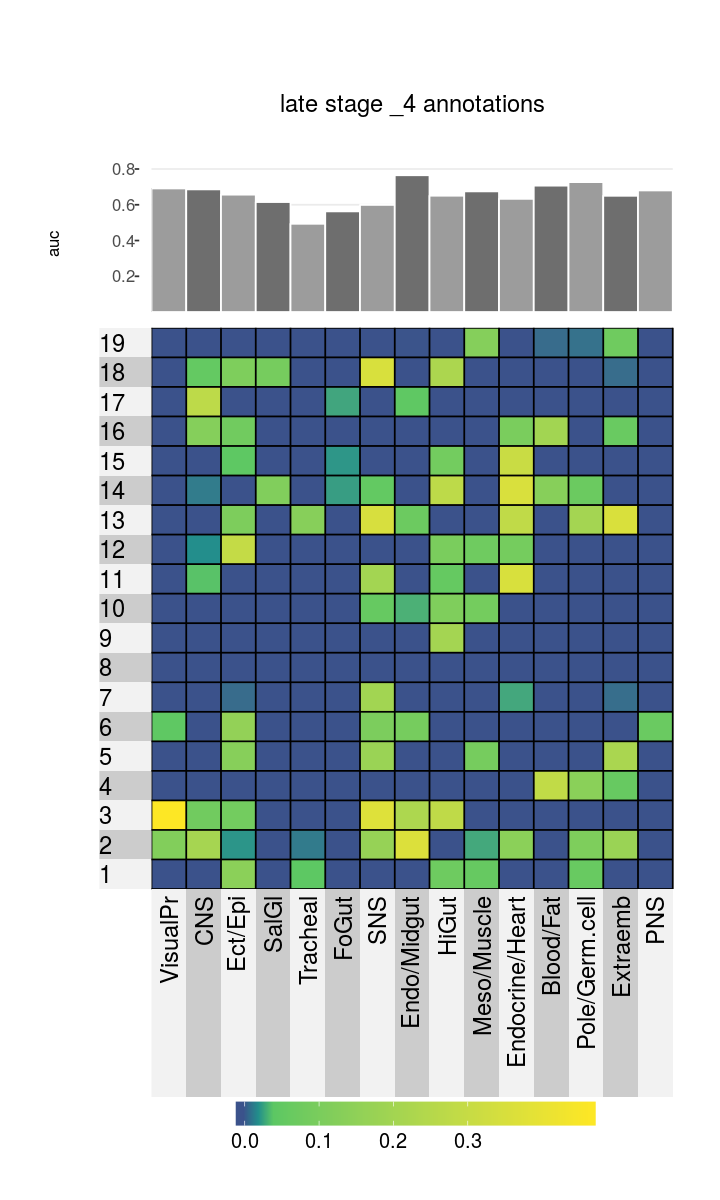

In [46]:
options(repr.plot.width = 6, repr.plot.height = 10)

superheat(abs(lasso_pred19$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right",
          yt = lasso_pred19$error, yt.axis.name = "auc",
          yt.plot.type = "bar", title = "late stage _4 annotations")


In [47]:
dict_file <- '../scripts/staNMFDicts/K=19/factorization_99.csv'
dict <- read.csv(file = dict_file, header = FALSE)[, -1]


In [48]:
source('../utils/plottingUtilities.R')

In [49]:
load('../data/lateData.Rdata')

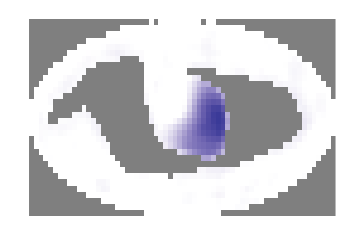

In [50]:
options(repr.plot.width = 3, repr.plot.height = 2)

plotImg(dict[, 2], late$template, FALSE)

# predictions using 5 PPs

In [51]:
alpha_file <- '../scripts/staNMFDicts/K=5/alpha_99.csv'
alpha5 <- read.csv(alpha_file)[, -1]

In [52]:
lasso_pred5 <- get_os_prediction_from_PP(alpha5, os)

[1] 658  80
[1]   5 658


In [9]:
# match PP's as best as we can

# match_PPs_by_dict <- function(dict, reference){
#     # we sort the dictionary by comparing it with a reference dictionary
#     remove_col <- c()
#     perm <- c()
#     for(i in 1:dim(reference)[2]){
#         diff <- t(as.matrix(dict)) %*% reference[, i]
#         perm_ <- order(diff, decreasing = TRUE)

#         perm_ <- perm_[!(perm_ %in% remove_col)]
#         perm <- c(perm, perm_[1])
#         remove_col <- c(remove_col, perm_[1])
#     }
#     perm <- perm[!is.na(perm)]
#     return(perm)
    
# }

# # staNMF_results_path <- './new_dicts/staNMFDicts2/'
# # iter2_results <- # load_dictionary_results(staNMF_results_path, 10, 25)
# # dict_shifted_x2 <- iter2_results$dict_shifted_x

# load('./new_results/late2.RData')

# perm <- match_PPs_by_dict(iter2_results$dict, late$dict)

In [10]:
foo <- lasso_pred2$coefficients[perm, ]
rownames(foo) <- 1:15

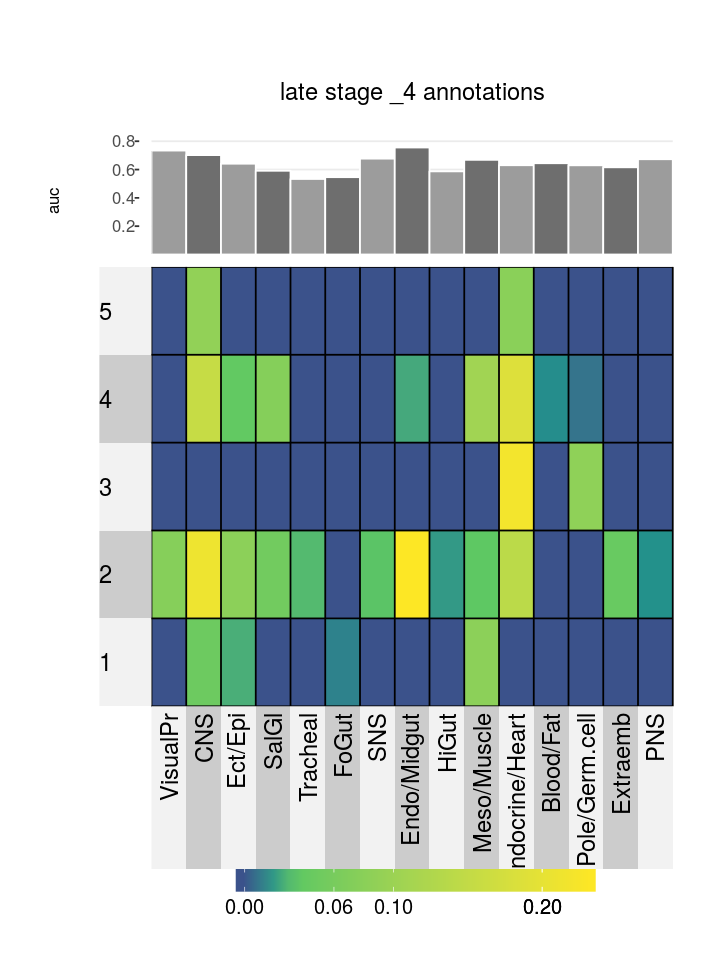

In [68]:
options(repr.plot.width = 6, repr.plot.height = 8)

superheat(abs(lasso_pred5$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right", 
          yt = lasso_pred5$error, yt.axis.name = "auc",
          yt.plot.type = "bar", title = "late stage _4 annotations")


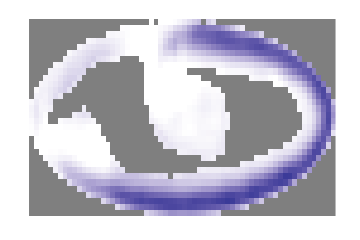

In [72]:
dict_file <- '../scripts/staNMFDicts/K=5/factorization_99.csv'
dict <- read.csv(file = dict_file, header = FALSE)[, -1]

options(repr.plot.width = 3, repr.plot.height = 2)

plotImg(dict[, 4], late$template, FALSE)

In [57]:
# predictions using full image

In [58]:
rownames(late$x) <- 1:dim(late$x)[1]

In [59]:
lasso_pred_full <- get_os_prediction_from_PP(late$x, os)

[1] 766  80
[1] 1143  766


In [64]:
os.names <- colnames(os)
CV.late4 <- os.names[grep("_4", os.names)]
CV.late4 <- CV.late4[CV.late4 != 'imagPR_4']

# dataframe for full data
error_lasso_full_ <- lasso_pred_full$error
rownames(error_lasso_full_) <- c()
error_lasso_full_df <- data.frame(auc = error_lasso_full_, os = sub("_4*", " ", CV.late4))
error_lasso_full_df$features <- 'full'

# dataframe for 19 PP
error_lasso19_ <- lasso_pred19$error
rownames(error_lasso19_) <- c()
error_lasso19_df <- data.frame(auc = error_lasso19_, os = sub("_4*", " ", CV.late4))
error_lasso19_df$features <- '19_PP'

# dataframe for PP from second iteration
error_lasso5_ <- lasso_pred5$error
rownames(error_lasso5_) <- c()
error_lasso5_df <- data.frame(auc = error_lasso5_, os = sub("_4*", " ", CV.late4))
error_lasso5_df$features <- '05_PP'



In [65]:
library(tidyverse)

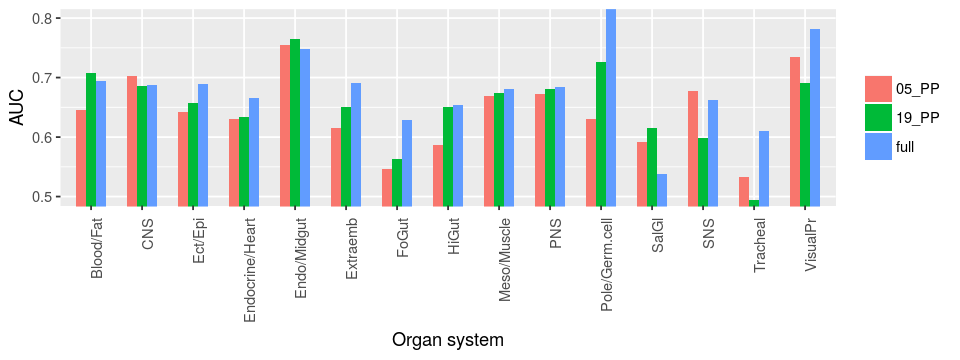

In [66]:
error_df <- rbind(error_lasso19_df, error_lasso5_df, error_lasso_full_df)

blank_theme <-   theme_bw() +
  theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) 


library(ggplot2)
library(repr)
options(repr.plot.width=8, repr.plot.height=3)

ggplot(error_df ,aes(x=os,y=auc,fill=factor(features), width=.6))+
  geom_bar(stat="identity",position="dodge")+
  xlab("Organ system")+ylab("AUC") + theme(axis.text.x=element_text(angle=90,hjust=1)) + 
    coord_cartesian(ylim=c(0.5,0.8)) + 
    guides(fill=guide_legend(title="")) 



In [18]:
library(tidyverse)

In [19]:
load('./new_results/late2.RData')

In [20]:
options(repr.plot.width=2, repr.plot.height=4/3)

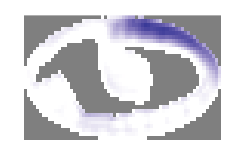

In [72]:
plotImg(iter2_results$dict[, 7], late$template, FALSE)

In [45]:
os_coeffs_normalized <- sweep(abs(lasso_pred2$coefficients), 1, rowSums(abs(lasso_pred2$coefficients)), FUN="/")

In [76]:
colnames(os_coeffs_normalized)[13]

[1] "Pole/Germ.cell "

In [78]:
sort(os_coeffs_normalized[, 1], decreasing = TRUE)

5         12         13          1          2          3          4 
0.25494473 0.12243214 0.10856111 0.03966346 0.00000000 0.00000000 0.00000000 
         6          7          8          9         10         11         14 
0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 
        15 
0.00000000

In [22]:
alpha_normalized <- sweep(iter2_results$alpha, 2, colSums(iter2_results$alpha), FUN="/")

In [33]:
sort(alpha_normalized[6, ], decreasing = TRUE)

,osk,eyg,HLHm5,sens,CG12489,btn,btn.1,HLHm5.1,btn.2,fd96Ca,⋯,tll,bap,byn,byn.1,Dl.1,otp.3,otp.4,bowl.2,bowl.3,fkh.1
6,1,1,0.7868913,0.6879234,0.6609271,0.6486228,0.5773184,0.5692828,0.5348866,0.5331604,⋯,0,0,0,0,0,0,0,0,0,0


In [34]:
plotImg(iter2_results$x[, 'Tkr'], krate$template, FALSE)

ERROR: Error in which(template == 1, arr.ind = TRUE): object 'krate' not found


In [173]:
iter2_results$alpha[, 'Ugt36Bc']

[1] 3.4133063 0.9915932 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 1.2938196 0.0000000 0.0000000 0.0000000 0.0000000 6.9136208 0.0000000
[15] 0.8401294

In [174]:
which(iter2_results$alpha[, 'Ugt36Bc'] > 0)

[1]  1  2  8 13 15

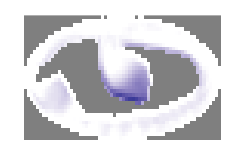

In [187]:
plotImg(iter2_results$dict[, 15], late$template, FALSE)

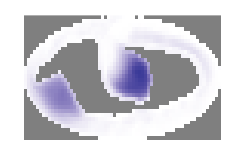

In [189]:
plotImg(as.matrix(iter2_results$dict) %*% iter2_results$alpha[, 'Ugt36Bc'], late$template, FALSE)